<a href="https://colab.research.google.com/github/Alex112525/LangGraph-notebooks/blob/main/Reduce_Filter_and_Trim_messages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install langgraph langgraph-sdk langgraph-checkpoint-sqlite langsmith langchain-community langchain-core langchain-openai tavily-python wikipedia

In [10]:
import os
from google.colab import userdata
from IPython.display import Image, display

In [9]:
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

In [4]:
#Azure OpenAI
os.environ["AZURE_OPENAI_API_KEY"] = userdata.get('Azure_openai')
os.environ["AZURE_OPENAI_ENDPOINT"] = userdata.get('Endpoint_openai')

#LangSmith
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LangSmith')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-agents-practice"

### Utils Funtions

In [21]:
def get_model(model:str="DASH-mini", temp:float=0.1, max_tokens:int=200):
  """Get model from Azure OpenAI"""
  model = AzureChatOpenAI(
        openai_api_version="2024-02-15-preview",
        azure_deployment=model,
        temperature=temp,
        max_tokens=max_tokens,
    )
  return model

In [22]:
gpt4o_mini = get_model()

### Message as State

In [7]:
messages = [AIMessage("So you said you were researching about Attention", name="Bot")]
messages.append(HumanMessage("Yes I know about Attention. But what others should I learn about?", name="Alex"))

for m in messages:
  m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching about Attention
================================ Human Message =================================
Name: Alex

Yes I know about Attention. But what others should I learn about?


In [8]:
gpt4o_mini.invoke(messages)

AIMessage(content="Great! If you're already familiar with Attention mechanisms, here are some other important concepts and techniques in deep learning and natural language processing that you might find valuable:\n\n1. **Transformers**: Understanding the architecture that utilizes Attention mechanisms, which has revolutionized NLP tasks.\n\n2. **Recurrent Neural Networks (RNNs)**: Learn about sequence modeling and how RNNs handle sequential data, including LSTMs and GRUs.\n\n3. **Convolutional Neural Networks (CNNs)**:", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 100, 'prompt_tokens': 37, 'total_tokens': 137, 'completion_tokens_details': None}, 'model_name': 'gpt-4o-mini', 'system_fingerprint': 'fp_878413d04d', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {}}], 'finish_reason': 'length', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 

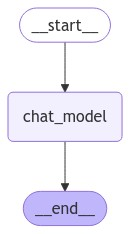

In [13]:
# Node
def chat_model_node(state: MessagesState):
  return {"messages": gpt4o_mini.invoke(state["messages"])}

# Builder
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
output = graph.invoke({"messages": messages})

for m in output["messages"]:
  m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching about Attention
================================ Human Message =================================
Name: Alex

Yes I know about Attention. But what others should I learn about?
================================== Ai Message ==================================

Great! If you're already familiar with Attention mechanisms, here are some related topics and concepts you might find interesting to explore:

1. **Transformers**: Understand the architecture that utilizes Attention mechanisms extensively, especially in natural language processing (NLP) tasks.

2. **Self-Attention**: Dive deeper into how self-attention works within the Transformer model and its applications.

3. **Multi-Head Attention**: Learn about how multiple attention heads can capture different aspects of the input data.


### Reducer

When working with messages in large conversations, we need to manage the length of the context - a large context can result in high token usage and latency if we are not careful.

In [15]:
from langchain_core.messages import RemoveMessage

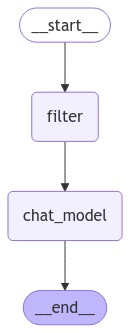

In [32]:
# Nodes
def filter_messages(state: MessagesState):
  # Keep just the two most recent messages
  delete_msg = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
  return {"messages": delete_msg}

def chat_model_node(state: MessagesState):
  return {"messages": gpt4o_mini.invoke(state["messages"])}

# Builder
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [33]:
# Message to test the filter
messages = [AIMessage("Hello, how I can help you?", name="Bot", id="1")]
messages.append(HumanMessage("Hello", name="Alex", id="2"))
messages.append(AIMessage("So you said you were researching about Artificial Intelligence", name="Bot", id="3"))
messages.append(HumanMessage("Yes I know about Neural Networks. But what others should I learn about?", name="Alex", id="4"))

# Invoke
output = graph.invoke({"messages": messages})
for m in output["messages"]:
  m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching about Artificial Intelligence
================================ Human Message =================================
Name: Alex

Yes I know about Neural Networks. But what others should I learn about?
================================== Ai Message ==================================

Great! In addition to neural networks, here are some key areas in artificial intelligence that you might find interesting:

1. **Machine Learning (ML)**: Understand the different types of ML, including supervised, unsupervised, and reinforcement learning. Familiarize yourself with algorithms like decision trees, support vector machines, and clustering techniques.

2. **Deep Learning**: Dive deeper into advanced neural network architectures, such as convolutional neural networks (CNNs) for image processing and recurrent neural networks (RNNs) for sequence data.

3. **Natural Language Processi

### Filtering messages

If you don't want to modify the graph, you can simply filter the message that the model receives using slicing.

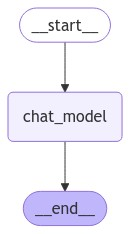

In [37]:
# Node
def chat_model_node(state: MessagesState):
  return {"messages": gpt4o_mini.invoke(state["messages"][-1:])}

# Builder
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [34]:
# Message to test the filter
messages.append(output["messages"][-1])
messages.append(HumanMessage("Tell me more about Reinforcement Learning ", name="Alex"))

In [35]:
for m in messages:
  m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hello, how I can help you?
================================ Human Message =================================
Name: Alex

Hello
================================== Ai Message ==================================
Name: Bot

So you said you were researching about Artificial Intelligence
================================ Human Message =================================
Name: Alex

Yes I know about Neural Networks. But what others should I learn about?
================================== Ai Message ==================================

Great! In addition to neural networks, here are some key areas in artificial intelligence that you might find interesting:

1. **Machine Learning (ML)**: Understand the different types of ML, including supervised, unsupervised, and reinforcement learning. Familiarize yourself with algorithms like decision trees, support vector machines, and clustering techniques.

2. **Deep Lea

In [38]:
# Invoke, using filtering
output = graph.invoke({"messages": messages})
for m in output["messages"]:
  m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hello, how I can help you?
================================ Human Message =================================
Name: Alex

Hello
================================== Ai Message ==================================
Name: Bot

So you said you were researching about Artificial Intelligence
================================ Human Message =================================
Name: Alex

Yes I know about Neural Networks. But what others should I learn about?
================================== Ai Message ==================================

Great! In addition to neural networks, here are some key areas in artificial intelligence that you might find interesting:

1. **Machine Learning (ML)**: Understand the different types of ML, including supervised, unsupervised, and reinforcement learning. Familiarize yourself with algorithms like decision trees, support vector machines, and clustering techniques.

2. **Deep Lea

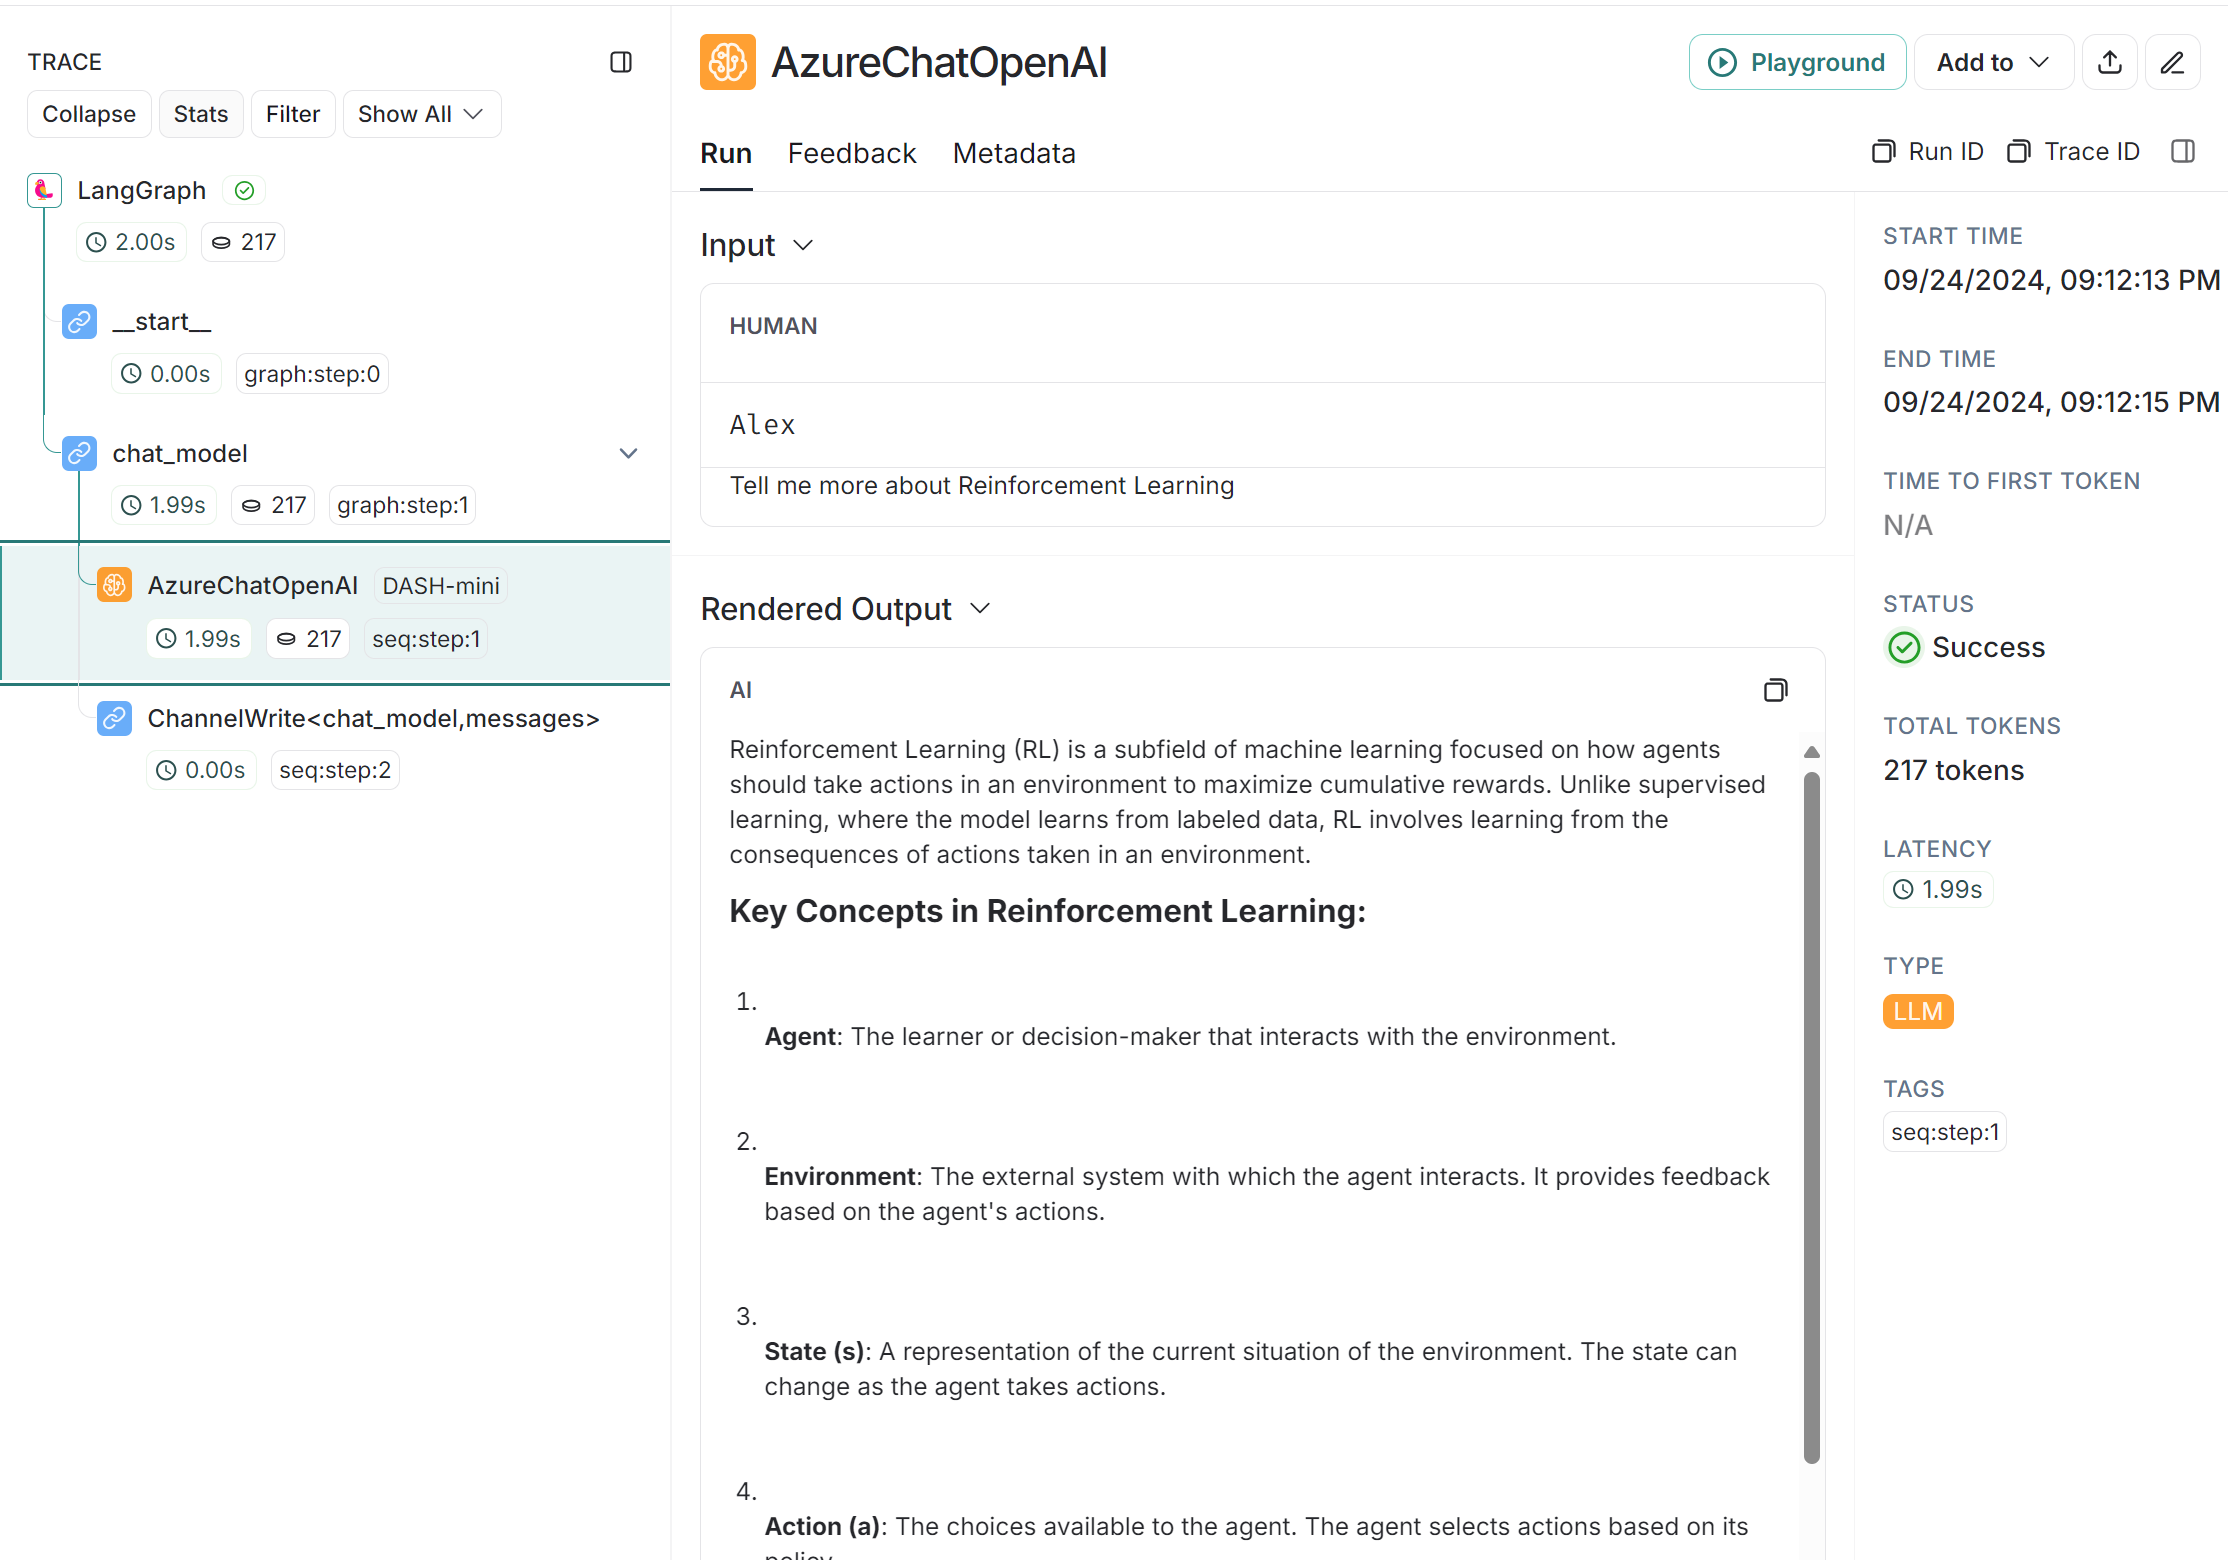

### Trim messages

This approach is based on a fixed number of tokens. That is, the message history is restricted to a fixed number of tokens.

In [39]:
from langchain_core.messages import trim_messages

In [56]:
import tiktoken
from langchain_core.messages import BaseMessage, ToolMessage


def str_token_counter(text: str) -> int:
    enc = tiktoken.get_encoding("o200k_base")
    return len(enc.encode(text))


def tiktoken_counter(messages: list[BaseMessage]) -> int:
    num_tokens = 3  # every reply is primed with <|start|>assistant<|message|>
    tokens_per_message = 3
    tokens_per_name = 1
    for msg in messages:
        if isinstance(msg, HumanMessage):
            role = "user"
        elif isinstance(msg, AIMessage):
            role = "assistant"
        elif isinstance(msg, ToolMessage):
            role = "tool"
        elif isinstance(msg, SystemMessage):
            role = "system"
        else:
            raise ValueError(f"Unsupported messages type {msg.__class__}")
        num_tokens += (
            tokens_per_message
            + str_token_counter(role)
            + str_token_counter(msg.content)
        )
        if msg.name:
            num_tokens += tokens_per_name + str_token_counter(msg.name)
    return num_tokens

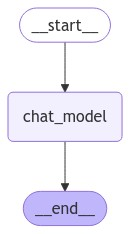

In [59]:
# Node
def chat_model_node(state: MessagesState):
  messages = trim_messages(
      state["messages"],
      max_tokens = 150,
      strategy="last",
      token_counter=tiktoken_counter,
      allow_partial=True
  )
  return {"messages": gpt4o_mini.invoke(messages)}

# Builder
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [42]:
messages.append(output["messages"][-1])
messages.append(HumanMessage("How can I decide the Policy?", name="Alex"))

In [60]:
output = graph.invoke({"messages": messages})
for m in output["messages"]:
  m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hello, how I can help you?
================================ Human Message =================================
Name: Alex

Hello
================================== Ai Message ==================================
Name: Bot

So you said you were researching about Artificial Intelligence
================================ Human Message =================================
Name: Alex

Yes I know about Neural Networks. But what others should I learn about?
================================== Ai Message ==================================

Great! In addition to neural networks, here are some key areas in artificial intelligence that you might find interesting:

1. **Machine Learning (ML)**: Understand the different types of ML, including supervised, unsupervised, and reinforcement learning. Familiarize yourself with algorithms like decision trees, support vector machines, and clustering techniques.

2. **Deep Lea

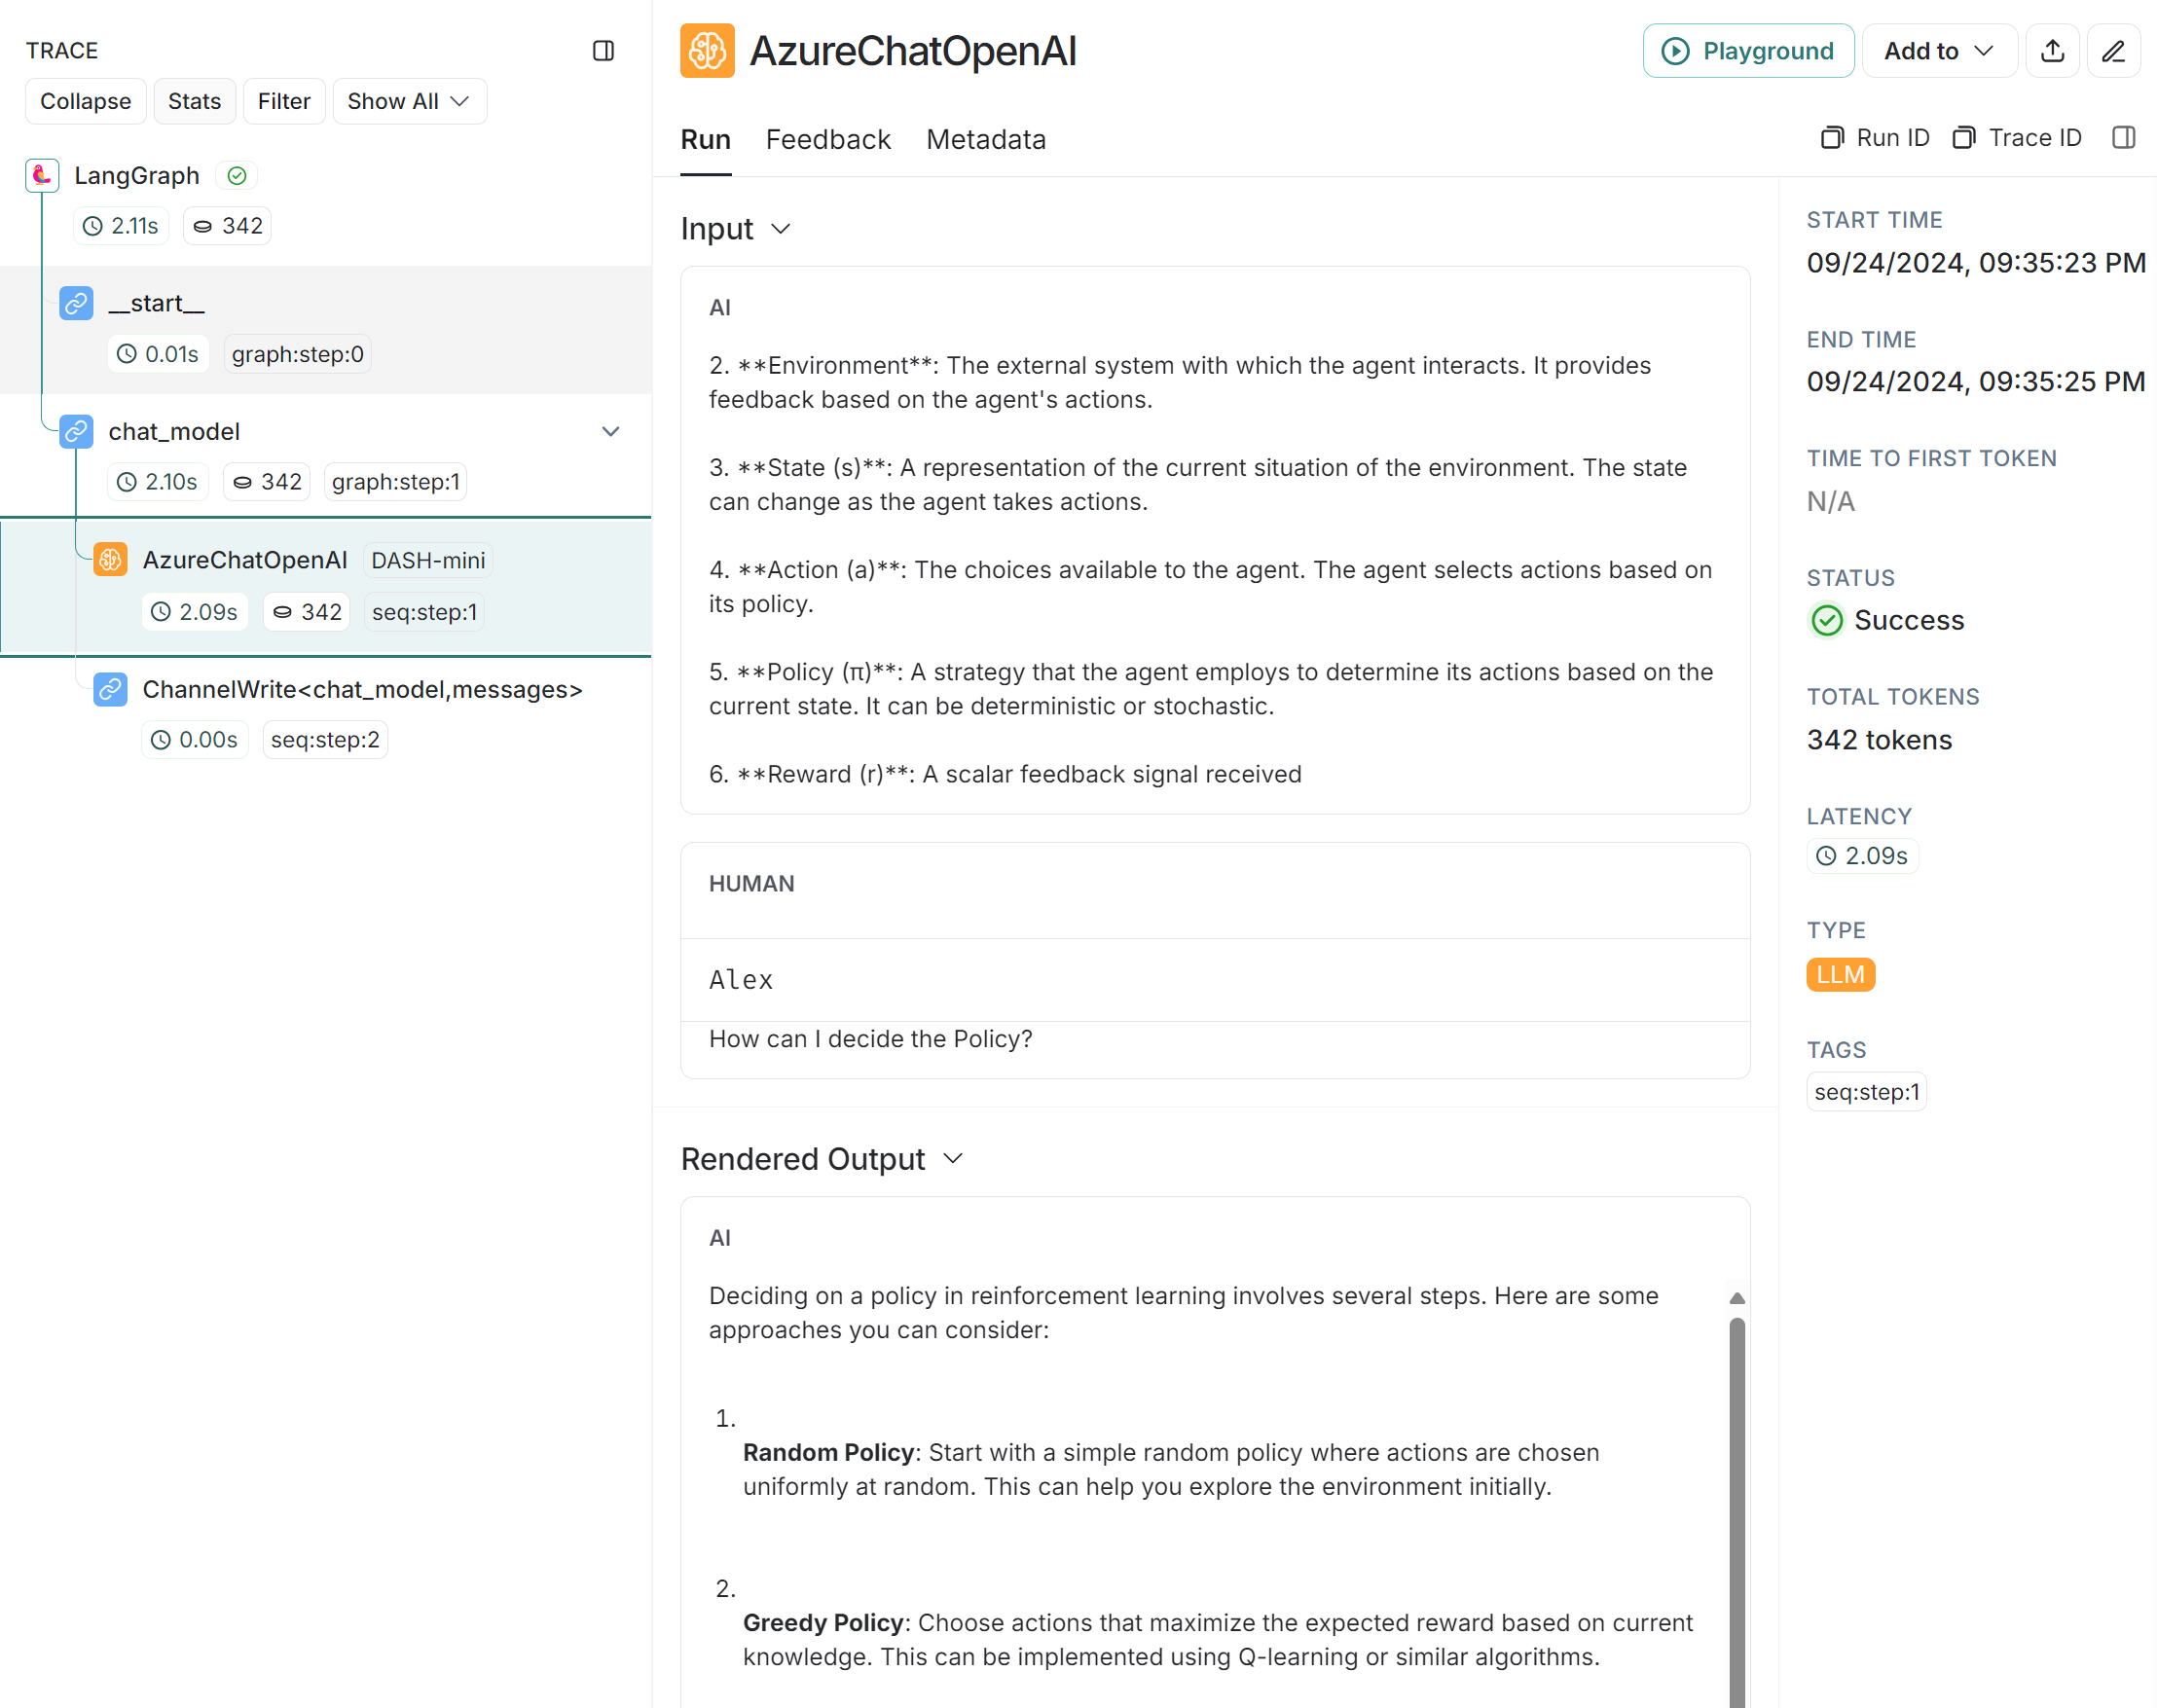